# Executive Orders Knowledge Graph (GLiNER)

This notebook builds a knowledge graph from **Executive Orders** using **GLiNER**.
It mirrors the approach used for Congressional Bills.

In [ ]:
!pip install gliner networkx matplotlib tqdm -q

In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from gliner import GLiNER
from tqdm import tqdm
import os

## 1. Load Data
Loading `orders.json`.

In [3]:
# Load orders data
target_file = 'orders.json'

if not os.path.exists(target_file):
    print(f"Warning: {target_file} not found. Using dummy data.")
    data = [
        {"text": "By the authority vested in me as President by the Constitution and the laws of the United States of America, including the Federal Property and Administrative Services Act of 1949, it is hereby ordered as follows: Section 1. Policy."},
        {"text": "The Secretary of Energy shall coordinate with the Administrator of the Environmental Protection Agency to reduce emissions."}
    ]
else:
    print(f"Loading data from {target_file}...")
    with open(target_file, 'r') as f:
        raw_data = json.load(f)
    
    data = []
    if isinstance(raw_data, list):
        # Limit for prototype speed
        for item in raw_data: 
            text = ""
            # Try various common keys
            if isinstance(item, str):
                text = item
            elif isinstance(item, dict):
                if 'text' in item: text = item['text']
                elif 'content' in item: text = item['content']
                elif 'description' in item: text = item['description']
                elif 'summary' in item: text = item['summary']
                # Handle chunk structure if present
                elif 'chunk_text' in item:
                     if isinstance(item['chunk_text'], dict):
                         text = item['chunk_text'].get('text', '')
                     else:
                         text = str(item['chunk_text'])
            
            if text:
                data.append({'text': text})
    else:
        print("Unknown JSON structure")
        data = []
        
    print(f"Loaded {len(data)} items.")

Loading data from orders.json...
Loaded 1471 items.


## 2. Initialize GLiNER
Using the Universal Entity Ontology.

In [4]:
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

labels = [
    # People & Roles
    "Person", "Legislator", "Judge", "President", "Secretary",
    
    # Institutions
    "Committee", "Government Agency", "Court", "Organization", "Department",
    
    # Legal Docs
    "Bill", "Statute", "Case Citation", "Executive Order", "Act",
    
    # Context
    "Date", "Location", "Topic"
]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## 3. Build the Graph

In [5]:
G = nx.Graph()

for i, item in enumerate(tqdm(data)):
    text = item.get('text', '')
    if not text or len(text) < 50: continue
    
    # Create Chunk Node
    chunk_id = f"order_chunk_{i}"
    G.add_node(chunk_id, type="Chunk", text=text[:50]+"...")
    
    # Extract Entities
    try:
        entities = model.predict_entities(text, labels)
    except Exception as e:
        print(f"Error processing chunk {i}: {e}")
        continue
    
    entity_names = []
    for entity in entities:
        label = entity['label']
        name = entity['text'].strip()
        
        # Add Entity Node
        G.add_node(name, type=label)
        
        # Edge: Chunk -> Entity
        G.add_edge(chunk_id, name, relation="MENTIONS")
        
        entity_names.append(name)
    
    # Edge: Entity <-> Entity (Co-occurrence)
    import itertools
    for e1, e2 in itertools.combinations(entity_names, 2):
        if not G.has_edge(e1, e2):
            G.add_edge(e1, e2, relation="CO_OCCURS", weight=1)
        else:
            G[e1][e2]['weight'] += 1

print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

  0%|          | 3/1471 [00:01<08:36,  2.84it/s]/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 397 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
  2%|▏         | 27/1471 [00:07<07:34,  3.18it/s]/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 601 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
  3%|▎         | 37/1471 [00:09<04:41,  5.10it/s]/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 476 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch

Graph constructed: 4541 nodes, 33374 edges.


## 4. Visualize

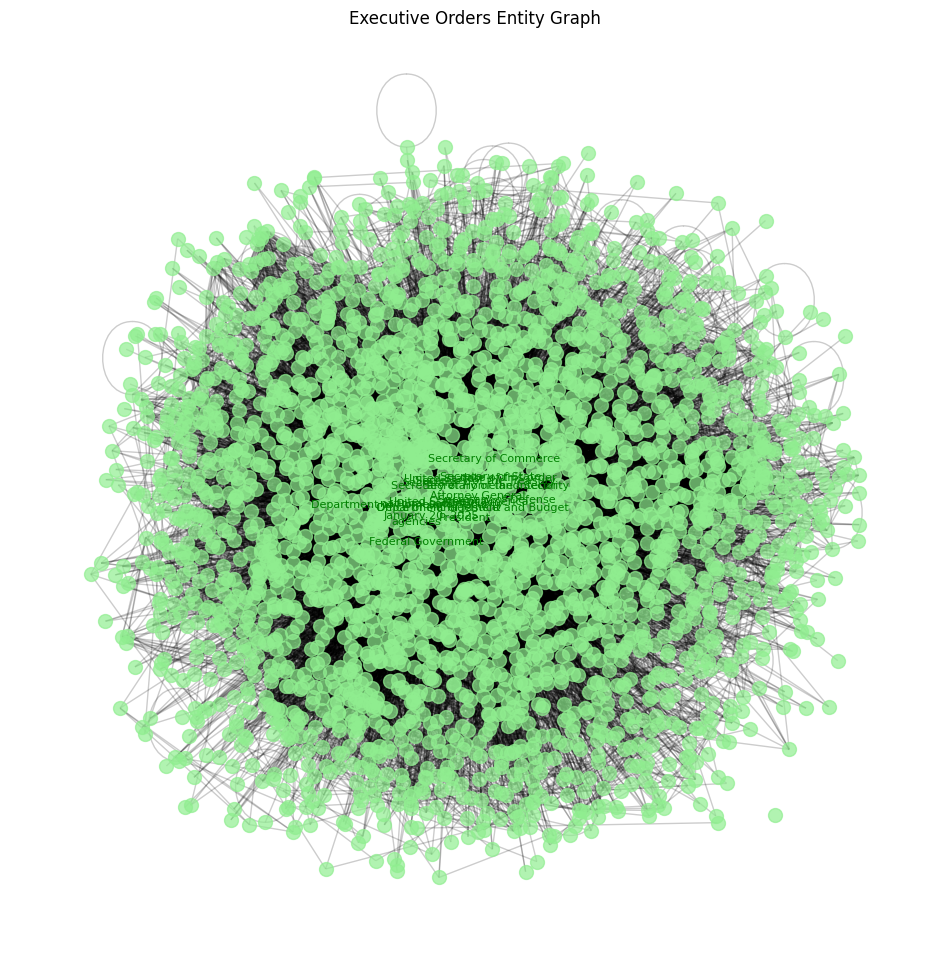

In [6]:
plt.figure(figsize=(12, 12))

# Filter out Chunk nodes for cleaner visualization
entity_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] != 'Chunk']
subgraph = G.subgraph(entity_nodes)

if len(subgraph.nodes()) > 0:
    pos = nx.spring_layout(subgraph, k=0.15, iterations=20)
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color="lightgreen", alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
    
    final_labels = {}
    degrees = dict(subgraph.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:20]
    for node in top_nodes:
        final_labels[node] = node
        
    nx.draw_networkx_labels(subgraph, pos, labels=final_labels, font_size=8, font_color="green")
    
    plt.title("Executive Orders Entity Graph")
    plt.axis('off')
    plt.show()
else:
    print("Not enough entity nodes to visualize.")

In [7]:
nx.write_gexf(G, "orders_knowledge_graph.gexf")
print("Graph saved to orders_knowledge_graph.gexf")

Graph saved to orders_knowledge_graph.gexf
